<a href="https://colab.research.google.com/github/anhdang000/obstacles_localization/blob/main/obstacles_localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Idea: 
Create U-V-disparity maps from original disparity maps in order to localize obstacles. The algorithm is to indicate interested regions which need extracting Local Pattern features.

Output: Binary images where '1' and '0' values refer existences and non-existences of obstacle(s).


In [ ]:
from google.colab import drive
drive.mount('./gdrive')

%cd /content/gdrive/MyDrive/Colab\ Notebooks/detection_research

Mounted at ./gdrive
/content/gdrive/MyDrive/Colab Notebooks/detection_research


In [ ]:
!nvidia-smi

Fri Apr 30 03:07:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import sys
import os
from os.path import join
import random
import numpy as np
import cv2
import glob2
import time
import math
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from google.colab.patches import cv2_imshow

DISPARITY_MAP_DIR = './stereo_datasets/training/disparity/'
ORIGINAL_IMG_DIR = './stereo_datasets/training/image_2'

In [100]:
class UVmapGenerator():
    def __init__(self, disp_dir):
        self.disp_dir = disp_dir
        self.disp_ids = os.listdir(self.disp_dir)
        self.num_disp_maps = len(self.disp_ids)

        print(f'{self.num_disp_maps} disparity maps found!')


    def onehot_initialization(self, mat):
        '''
        to get a 3d matrix of the world view
        '''
        ncols = mat.max() + 1
        out = np.zeros(mat.shape + (ncols,), dtype=int)
        out[self.all_idx(mat, axis=2)] = 1
        return out


    def all_idx(self, idx, axis):
        '''
        to get the necessary indices
        '''
        grid = np.ogrid[tuple(map(slice, idx.shape))]
        grid.insert(axis, idx)
        return tuple(grid)


    def get_uv_disparity(self, depth_map):
        '''
        uses the depth_map to find u and v disparity
        '''
        # using disparity as a measure of depth, generating one-hot world-view
        world_view = self.onehot_initialization(depth_map)
        # project the world views to get disparity maps
        u_disparity = np.sum(world_view, axis=0).T
        v_disparity = np.sum(world_view, axis=1)
        return v_disparity, u_disparity


    def draw_hoglines(self, src, target='u'):
        dst = np.zeros(tuple(list(src.shape)+[3]))
        src = (src * 255).astype(np.uint8)
        edges = cv2.Canny(src, 70, 150, apertureSize=3)
        if target == 'u':
            linesP = cv2.HoughLinesP(edges, 1, np.pi / 2, 100, None, 10, 30)
        elif target == 'v':
            linesP = cv2.HoughLinesP(edges, 1, np.pi / 2, 100, None, 10, 30)

        if linesP is not None:
            linesP = np.squeeze(np.array(linesP))
            for i in range(linesP.shape[0]):
                l = linesP[i]
                try:
                    cv2.line(dst, (l[0], l[1]), (l[2], l[3]), (1, 1, 1), 1, cv2.LINE_AA)
                except:
                    pass

        return dst, linesP
    

    def visualize_uvmaps(self, num=4):
        indices = np.random.randint(self.num_disp_maps, size=num).tolist()

        fig = plt.figure(figsize=(30, num*3*5))
        for i in tqdm(range(num)):
            disp_map = cv2.imread(join(self.disp_dir, self.disp_ids[indices[i]]))
            disp_map = cv2.cvtColor(disp_map, cv2.COLOR_BGR2GRAY)
            v_disp, u_disp = self.get_uv_disparity(disp_map)

            ax1 = fig.add_subplot(num*3, 1, i*3+1)
            ax1.imshow(disp_map)
            ax1.set_title(f'{self.disp_ids[indices[i]]}')
            ax1.axis('off')

            v_ret, _ = self.draw_hoglines(v_disp, target='v')
            ax2 = fig.add_subplot(num*3, 1, i*3+2)
            ax2.imshow(v_ret, cmap='gray')
            ax2.set_title(f'V-Disp for {self.disp_ids[indices[i]]}')
            ax2.axis('off')

            u_ret, _ = self.draw_hoglines(u_disp, target='u')
            ax3 = fig.add_subplot(num*3, 1, i*3+3)
            ax3.imshow(u_ret, cmap='gray')
            ax3.set_title(f'U-Disp for {self.disp_ids[indices[i]]}')
            ax3.axis('off')


  0%|          | 0/4 [00:00<?, ?it/s]

7481 disparity maps found!


100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


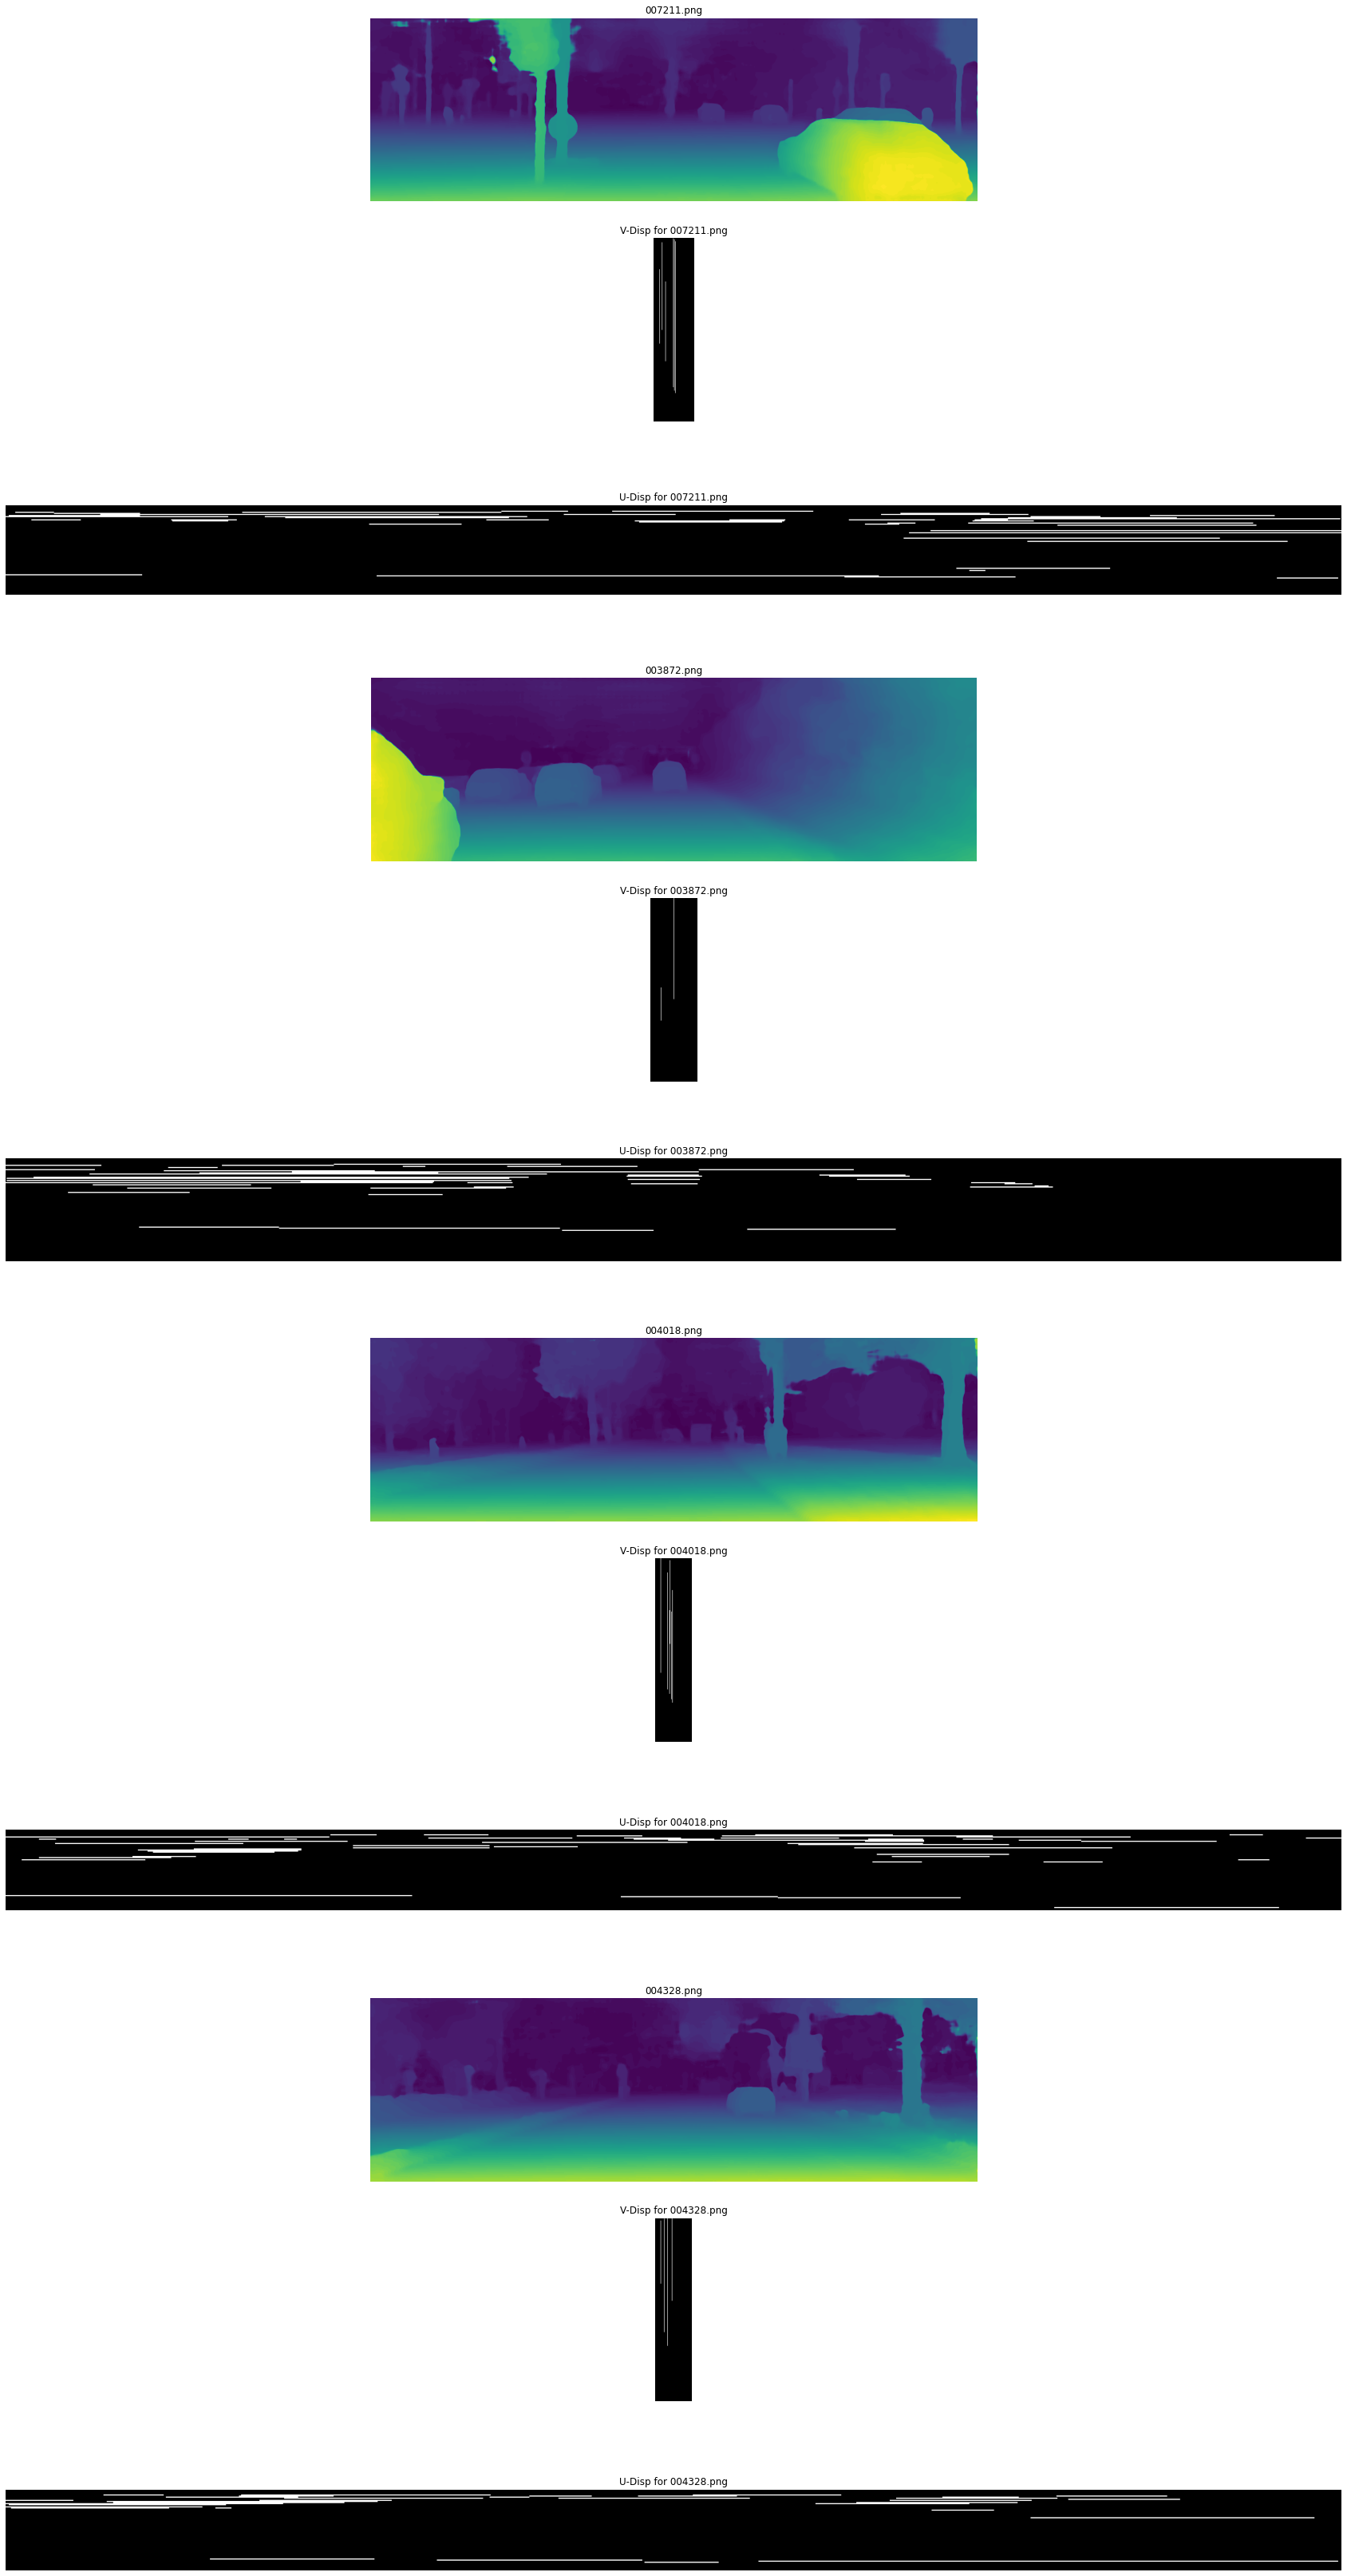

In [101]:
 uvmap_generator = UVmapGenerator(DISPARITY_MAP_DIR)
uvmap_generator.visualize_uvmaps()

In [102]:
class ObjectLocalizer(UVmapGenerator):
    def __init__(self, orig_dir, disp_dir):
        super().__init__(disp_dir)

        self.orig_dir = orig_dir
        self.orig_ids = self.disp_ids
        self.num_orig_maps = len(self.orig_ids)


    def compute_intersection(self, bb1, bb2):
            '''
            Args: 
                `bb1`, `bb2`: contain bounding boxes's info in the following format:
                                [xmin, ymin, xmax, ymax]
            '''
            
            assert bb1[0] < bb1[2]
            assert bb1[1] < bb1[3]
            assert bb2[0] < bb2[2]
            assert bb2[1] < bb2[3]
            x_left = max(bb1[0], bb2[0])
            y_top = max(bb1[1], bb2[1])
            x_right = min(bb1[2], bb2[2])
            y_bottom = min(bb1[3], bb2[3])
            
            return np.array([x_left, y_top, x_right, y_bottom])


    def compute_iou(self, bb1, bb2):
        '''
        Args: 
            `bb1`, `bb2`: contain bounding boxes's info in the following format:
                            [xmin, ymin, xmax, ymax, (class_id)]
        '''
        assert bb1[0] < bb1[2]
        assert bb1[1] < bb1[3]
        assert bb2[0] < bb2[2]
        assert bb2[1] < bb2[3]
        x_left = max(bb1[0], bb2[0])
        y_top = max(bb1[1], bb2[1])
        x_right = min(bb1[2], bb2[2])
        y_bottom = min(bb1[3], bb2[3])
        if x_right < x_left or y_bottom < y_top:
            return 0.0
        intersection_area = (x_right - x_left) * (y_bottom - y_top)
        bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
        bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])
        iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
        assert iou >= 0.0
        assert iou <= 1.0
        
        return iou


    def get_obstacle_boxes(self, disp_map, epsilon=3):
        v_disp, u_disp = self.get_uv_disparity(disp_map)

        v_ret, v_lines = self.draw_hoglines(v_disp, target='v')
        u_ret, u_lines = self.draw_hoglines(u_disp, target='u')

        obstacles = np.zeros((1, 4))

        for i in range(u_lines.shape[0]):
            l = u_lines[i, :]
            disp_val = l[1]

            # Extend u_line into strip with a format of [xmin, ymin, xmax, ymax]
            xmin = min(l[0], l[2])
            xmax = max(l[0], l[2])
            u_box = np.array([xmin, 0, xmax, disp_map.shape[0]])
            
            # Get corresponding value in V-Disparity
            if len(v_lines.shape) == 1:
                v_lines = v_lines.reshape((1, 4))
            mask = np.logical_and(
                v_lines[:, 0] >= disp_val-epsilon, 
                v_lines[:, 0] <= disp_val+epsilon
                )
            corr_lines = v_lines[mask, :]
            n_lines = corr_lines.shape[0]

            # Bounding boxes for corresponding V-Disparity lines
            x1 = np.array([0]*n_lines).reshape((n_lines, 1))
            y1 = np.min(corr_lines[:, [1, 3]], axis=1, keepdims=True)
            x2 = np.array([disp_map.shape[1]]*n_lines).reshape((n_lines, 1))
            y2 = np.max(corr_lines[:, [1, 3]], axis=1, keepdims=True)
            corr_boxes = np.hstack([x1, y1, x2, y2])
            if corr_boxes.shape[0] > 0:
                intersects = np.apply_along_axis(self.compute_intersection, 1, corr_boxes, u_box)
                obstacles = np.vstack([obstacles, intersects])

        return obstacles


    def draw_annotations(self, annos, ax):
        cmap = plt.cm.get_cmap('hsv', annos.shape[0])

        for i, (xmin, ymin, xmax, ymax) in enumerate(annos):
            w = xmax - xmin
            h = ymax - ymin
            rect = mpatches.Rectangle(
                (xmin, ymin), w, h, 
                fill=False, 
                edgecolor=cmap(i), 
                linewidth=1.2
            )
            ax.add_patch(rect)


    def segment(self, src, annos):
        key = random.sample(list(range(256)), 3)

        # Fill with computed boxes
        for i, (xmin, ymin, xmax, ymax) in enumerate(annos):
            xmin = int(xmin)
            ymin = int(ymin)
            xmax = int(xmax)
            ymax = int(ymax)

            src[ymin:ymax, xmin:xmax, 0] = key[0]
            src[ymin:ymax, xmin:xmax, 1] = key[1]
            src[ymin:ymax, xmin:xmax, 2] = key[2]

        mask = np.logical_and(
            src[:, :, 0] == key[0],
            src[:, :, 1] == key[1],
            src[:, :, 2] == key[2]
        )
        segmented = np.where(mask, 255, 0)
        
        return segmented / 255


    def visualize(self, num=4):
        indices = np.random.randint(self.num_disp_maps, size=num).tolist()

        fig = plt.figure(figsize=(30, num*3*6))
        for i in tqdm(range(num)):
            ax1 = fig.add_subplot(num*3, 1, i*3+1)
            disp_map = cv2.imread(join(self.disp_dir, self.disp_ids[indices[i]]))
            disp_map = cv2.cvtColor(disp_map, cv2.COLOR_BGR2GRAY)
            ax1.imshow(disp_map)
            ax1.set_title(f'{self.disp_ids[indices[i]]}')
            ax1.axis('off')
            
            ax2 = fig.add_subplot(num*3, 1, i*3+2)
            src = cv2.imread(join(self.orig_dir, self.orig_ids[indices[i]]))
            src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
            annos = self.get_obstacle_boxes(disp_map)
            ax2.imshow(src)
            self.draw_annotations(annos, ax2)
            ax2.axis('off')

            ax3 = fig.add_subplot(num*3, 1, i*3+3)
            segmented = self.segment(src, annos)
            ax3.imshow(segmented)
            ax3.axis('off')
        

  0%|          | 0/4 [00:00<?, ?it/s]

7481 disparity maps found!


100%|██████████| 4/4 [00:05<00:00,  1.42s/it]


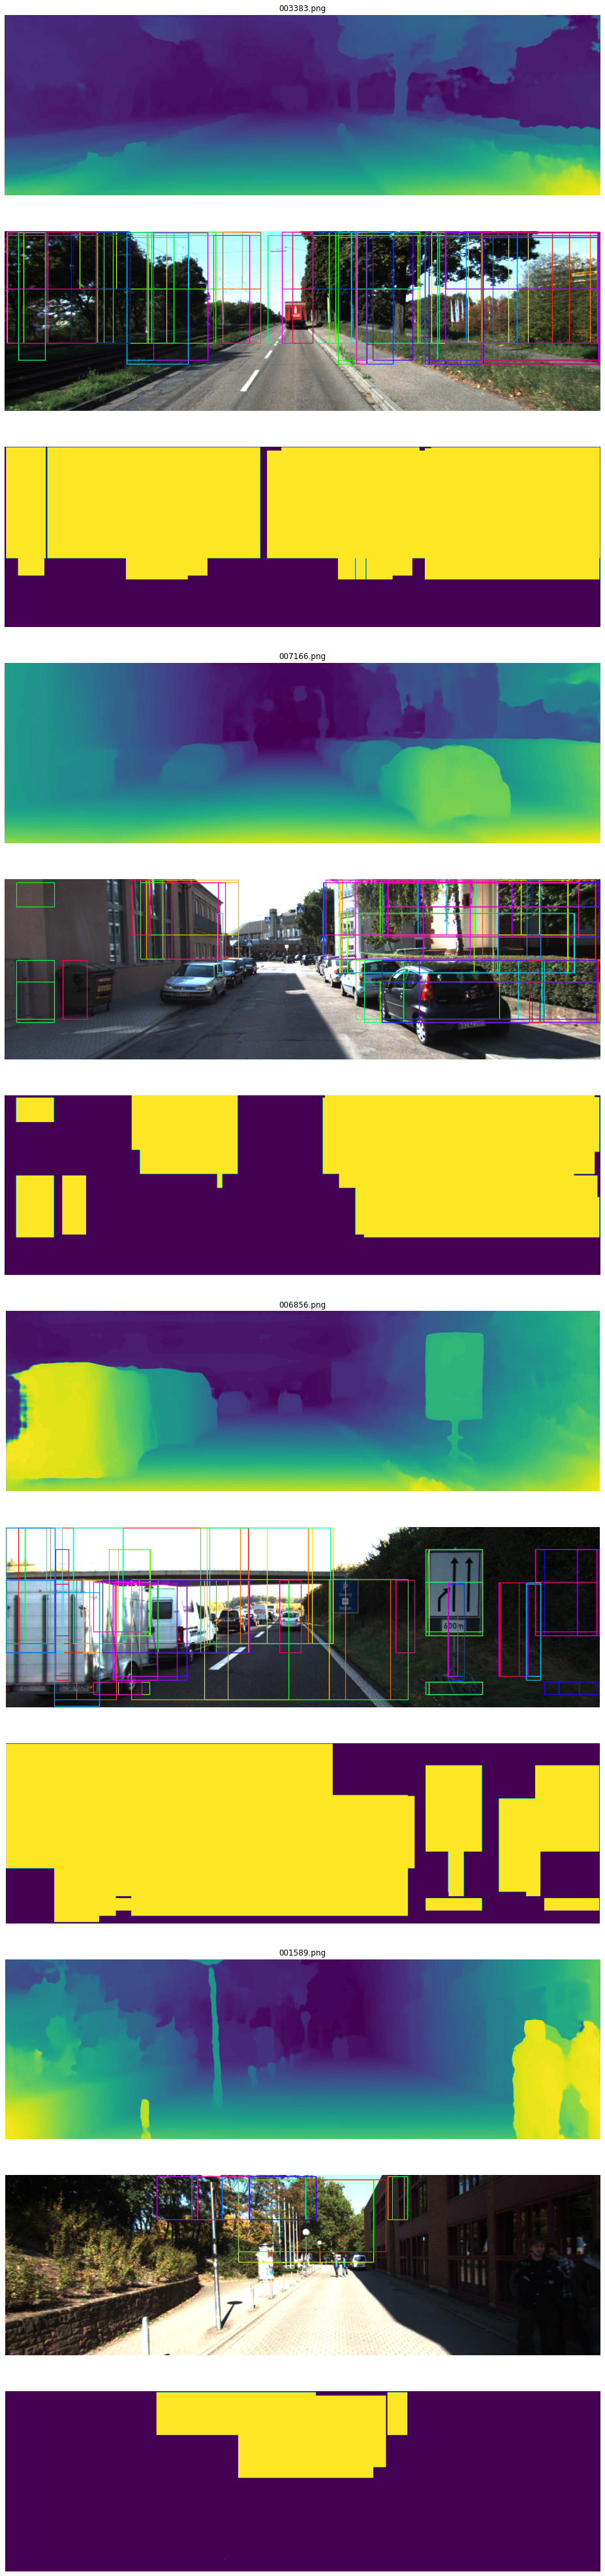

In [104]:
object_localizer = ObjectLocalizer(ORIGINAL_IMG_DIR, DISPARITY_MAP_DIR)
object_localizer.visualize()